In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
df = pd.read_hdf("../datasets/Casual_commentator.h5", key="casual_commentator")

In [4]:
model_sent = FastText.load("../models/user_level/fasttext_casual_commentator_senti.bin")

In [5]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [6]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [10]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"]  

    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [11]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [12]:
woman_terms_freq, man_terms_freq

([['she', 'woman', 'her', 'sister', 'daughter', 'girl', 'female', 'hers'],
  [513010, 262252, 140924, 15874, 26631, 90622, 27424, 1179]],
 [['he', 'his', 'man', 'male', 'him', 'son', 'brother', 'boy'],
  [680273, 186326, 257947, 32980, 622, 27487, 18492, 32210]])

In [13]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [14]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'woman', 'daughter', 'herself', 'sister', 'congresswoman', 'allegedly', 'hers', 'mother']
Top 10 (man) ['he', 'his', 'himself', 'trump', 'guy', 'son', 'president', 'donald', 'never', 'supporter']


In [15]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
191,shit,0.000,0.678,0.294
121,hell,0.020,0.918,0.565
93,hate,0.031,0.802,0.430
106,assassinate,0.051,0.969,0.722
163,dead,0.052,0.454,0.194


In [16]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
106,assassinate,0.051,0.969,0.722
121,hell,0.020,0.918,0.565
182,action,0.760,0.898,0.802
168,fight,0.531,0.868,0.809
162,mighty,0.855,0.837,0.936


In [17]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
3,president,0.677,0.622,0.973
43,presidential,0.612,0.656,0.972
162,mighty,0.855,0.837,0.936
165,chairman,0.656,0.567,0.933
26,leader,0.833,0.582,0.926


In [18]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
108,dead,0.052,0.454,0.194
167,rape,0.062,0.856,0.527
158,rapist,0.062,0.906,0.571
104,badly,0.073,0.509,0.286
194,falsely,0.083,0.480,0.265


In [19]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
113,threaten,0.104,0.958,0.590
158,rapist,0.062,0.906,0.571
169,troublemaker,0.260,0.900,0.596
167,rape,0.062,0.856,0.527
83,stripper,0.625,0.848,0.453


In [20]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
142,president,0.677,0.622,0.973
180,chairman,0.656,0.567,0.933
47,force,0.612,0.750,0.905
120,trump,0.640,0.716,0.898
128,congressman,0.438,0.471,0.877


In [21]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.04855743256687478 0.027339498705649473 0.0339907167656464


In [22]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.04133616258793971 0.024443896582914567 0.02559023708542713


In [23]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))


Bad key figure.labelsize in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


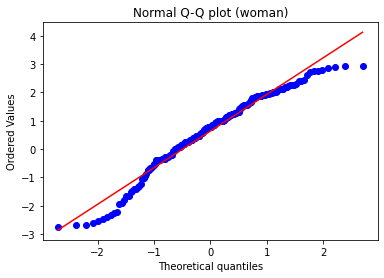

kolmogorv KstestResult(statistic=0.5723855163232511, pvalue=1.5354951696820035e-62)


In [24]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

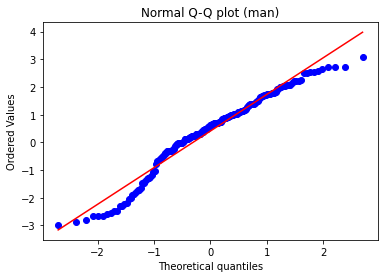

kolmogorv KstestResult(statistic=0.5634558618098905, pvalue=3.937135715853034e-60)


In [25]:
check_normal_dist(df_NRC_man, "arousal","man")

In [26]:
def apply_ttest_ind(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
  
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
                print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [27]:
apply_ttest_ind(df_NRC_woman, df_NRC_man,"arousal")
apply_ttest_ind(df_NRC_woman, df_NRC_man,"valence")
apply_ttest_ind(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=-0.708838, p=0.479
Same distribution (fail to reject H0)
200 199
welsh
Statistics=0.961290, p=0.337
Same distribution (fail to reject H0)
200 199
welsh
Statistics=-1.312720, p=0.190
Same distribution (fail to reject H0)
200 199


In [28]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5584773869346735 0.4911909547738694 0.5529798994974874
0.578885 0.47977000000000003 0.5302899999999999
